# Convex Optimization Project Proposal
This notebook describes a convex optimization problem to be studied in a one-week project as part of the course Convex Optimization.

Group: Mads Holst Aagaard Madsen, Emilie Knudsen Brun, and Oliver Lylloff


The optimization problem could be characterized as *covariance matrix fitting* where measured data, given by a  covariance matrix, is used to estimate a source covariance matrix through a propagation model.

Consider a measured (hermitian) covariance matrix $P\in\mathbb{C}^{M\times M}$ and a sound propagation model defined by transfer functions 

$$g_{m,n} = \frac{r_{m,n}}{r_{0,n}}e^{i\omega r_{m,n}/c}\quad m=1,...,M,\;n=1,...,N, $$

where $\omega = 2\pi f$ is the angular frequency, $c = 343 m/s$ is the speed of sound, $r_{0,n}$ is the distance from the center of the microphone array to the $n$'th source point, and $r_{m,n}$ is the distance between the $m$'th microphone and $n$'th source point. The transfer functions take into account the propagation of sound from the sources to the microphones. These are arranged in a transfer matrix $G\in\mathbb{C}^{N\times M}$. The model can be decribed by

$$P = GXG^H$$

where $X\in \mathbb{C}^{N\times N}$ is a covariance matrix at the source plane which is to be estimated.

The optimization problem can be stated as a SDP:

$$\begin{align} 
\begin{aligned} 
\underset{X}{\mathrm{minimize}}\quad & \|P-GXG^H\|_F^2\\ 
\mathrm{subject \ to} \quad & X\succeq 0\\ 
\end{aligned} 
\end{align}
$$

Several options for the solution can be persued:
* $X$ is diagonal and sparse. In this case the number of variables can be reduced greatly. Additionally a penalty function with regularization parameter $\lambda$ can be added to the objective function, e.g.,

$$\begin{align} 
\begin{aligned} 
\underset{X}{\mathrm{minimize}}\quad & \|P-GXG^H\|_F^2+\lambda\;\text{tr(diag}(X))\\ 
\mathrm{subject \ to} \quad & X\succeq 0\\ 
\end{aligned} 
\end{align}
$$

* Reducing the number of variables by introducing a matrix $M$ of same dimensions as $P$ and writing $X = G^HMG+D$, i.e.,

$$\begin{align} 
\begin{aligned} 
\underset{X}{\mathrm{minimize}}\quad & \|P-G(G^HMG+D)G^H\|_F^2+\lambda\sum_{i=1}^n(D_{ii}+e_i^TG^HMGe_i)\\ 
\mathrm{subject \ to} \quad & M\succeq 0\\
\quad & D_{ii}\geq0
\end{aligned} 
\end{align}
$$

and using $e_i^TG^HMGe_i = \sum_i tr(MGe_ie_iG^H)$, where $e_i$ is a unit-vector. Use resulting $M$ to obtain $X$.

* First-order methods and warmstart. The optimization problem should be solved multiple times for different $\omega$'s. Exploit warmstart capability of first-order methods and the assumption that covariance matrices does not change much between subsequent $\omega$'s.


### Data analysis and modelling
The visualization of noise using a microphone array is produced by a beamforming algorithm. One such example is given below:

In [3]:
function beamformer(Ns,X,Y,z0,f,rn,CSM)
    const M = size(rn,1)    # Number of microphones
    const omega = 2pi*f     # Angular frequency
    const c = 343           # Speed of sound
    
    r0 = sqrt(X.^2 + Y.^2 .+ z0^2)
    
    # Allocation of arrays
    rmn = Array(Float64,Ns,Ns,M);
    gj = Array(Complex128,Ns,Ns,M);
    b = Array(Complex128,Ns,Ns);
    
    # Compute transfer functions
    for i in 1:Ns
        for j in 1:Ns
            for m in 1:M
                rmn[i,j,m] = sqrt((X[i,j]-rn[m,1])^2+(Y[i,j]-rn[m,2])^2 + z0^2);
                gj[i,j,m] = (rmn[i,j,m]/r0[i,j])*exp(im*omega*rmn[i,j,m]/c);
            end
        end
    end

    CSM[eye(Bool,M)] = 0;    # Diagonal removal

    for i = 1:Ns
        for j = 1:Ns
            b[i,j] = (dot(vec(gj[i,j,:]),CSM*vec(gj[i,j,:])))/(M^2-M);
        end
    end
    return b,gj
end

beamformer (generic function with 1 method)

The experimental data used for this project is obtained from the Python package [Acoular](www.acoular.org). Time sampling of 56 microphones arranged in a microphone array can be found on the [Acoular Github page (a 6 MB download stored in HDF5 format)](https://github.com/acoular/acoular/blob/master/examples/example_data.h5?raw=true). The data is averaged and tranformed into the frequecy domain to obtain a covariance matrix. 

Below is an example of the covariance matrix and a beamforming map. Solving the optimization problem results in a matrix $X$ with a diagonal that can be used to visualize the noise distribution in the source plane with a much higher resolution than that of the beamforming map.

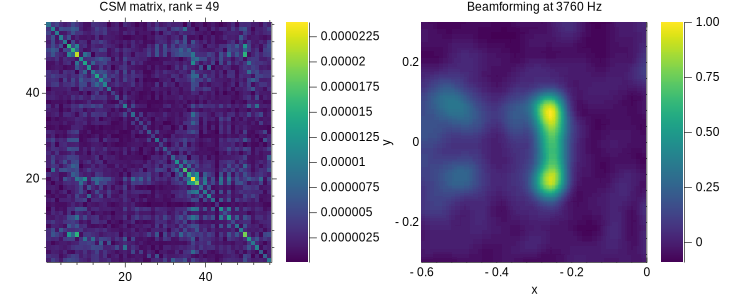

In [4]:
using MAT, GR
inline()

file = matopen("CSM_TE.mat")
CSM_TE = read(file, "CSM")
close(file)

file = matopen("micgeom.mat")
rn = read(file, "micgeom")
close(file)

Ns = 50    # i.e. N = Ns^2

id = 80
df = 47
f = id*df
rx = linspace(-0.6,0,Ns)
ry = linspace(-0.3,0.3,Ns)
X,Y = (Float64[i for i in rx, j in ry],Float64[j for i in rx, j in ry])

b,gj = beamformer(Ns,X,Y,0.68,f,rn,CSM_TE[:,:,id])

# Plot example

GR.figure(size=(750,300))
GR.subplot(1,2,1)
GR.heatmap(abs(flipdim(CSM_TE[:,:,id],1)),title="CSM matrix, rank = $(rank(CSM_TE[:,:,id]))")
GR.subplot(1,2,2)
GR.contourf(rx,ry,real(b)./maximum(real(b)),xlabel="x",ylabel="y",title="Beamforming at $f Hz")

## Background

The generation of electricity from renewable energy sources is more important than ever following the global agreement signed by 195 countries at the COP21 climate conference in Paris, December 2015. The long term goal, to limit the global average temperature increase to 2$^{\circ}$C, requires governments around the world to limit their dependence on fossil fuels and adapt renewable energy sources.

This goal requires development and installation of more wind turbines (onshore and offshore) in the following years. Noise regulations on wind turbines near urban areas can restrict the installation of new wind turbines and limit the potential energy production. The main noise from wind turbines is aerodynamic and arises from turbulence caused by the air flow around the wind turbine blades in motion. The aerodynamic noise increases with the size of the wind turbine and with a demand for more productive, and thus larger wind turbines, there is an increased interest in quantifying the aerodynamic noise from wind turbine blades. In the design stage, wind turbine blades undergo a wealth of tests and simulations to ensure that the specific design is efficient. A wind tunnel is used to test the aerodynamic properties by applying a controlled airflow to a section of the blade. The wind tunnel can also be used to localize and quantify the noise sources with a microphone array, however, this requires specially designed wind tunnels.

In typical experimental setups, a wind turbine wing section, i.e., airfoil, is placed in such a wind tunnel and a controlled air flow is applied. The aerodynamic noise generated on the airfoil can be measured with a microphone array.

## References
[Hoeltgen, L., Breuß, M., Herold, G., & Sarradj, E. (2016). Sparse l1 Regularisation of Matrix Valued Models for Acoustic Source Characterisation. arXiv preprint arXiv:1607.00171.](https://arxiv.org/abs/1607.00171)

[Herold, G., Sarradj, E., & Geyer, T. (2013). Covariance Matrix Fitting for Aeroacoustic Application.](http://www-docs.tu-cottbus.de/aeroakustik/public/veroeffentlichungen/herold_cmf_daga2013.pdf)

[Yardibi, T., Li, J., Stoica, P., & Cattafesta, L. N. (2008). Sparsity constrained deconvolution approaches for acoustic source mapping. Journal of the Acoustical Society of America, 123(5), 2631–2642.](http://dx.doi.org.proxy.findit.dtu.dk/10.1121/1.2896754)